In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

from matplotlib import pyplot as plt

from ihrem.timeslice import ms
from ihrem.analysis import stim
from ihrem.analysis import cycles

from ihrem.analysis import prc, prc_plot
from ihrem.figs_cpg import fig2

In [3]:
phase_time = ms(seconds=-5)

# Fig2c: multiple durations

In [4]:
reg_sel = fig2.load_reg_healthy_no_cap_light_pulses()

reg_sel

Taking 71/204 experiments


In [5]:
analysis_windows = stim.collect_analysis_windows(reg_sel, pulse_len=(0, ms(minutes=4))).sel(noisy=False)
reg_sel = reg_sel.sel_mask(analysis_windows['exp_name'].unique())

  0%|          | 0/71 [00:00<?, ?it/s]

Found 479 pulses in total


In [6]:
exp_beta_detailed = reg_sel.load_all_beta_traces_multi(area='CLA').normalize_by_quantiles()

load beta:   0%|          | 0/51 [00:00<?, ?it/s]

In [7]:
exp_beta_comb = exp_beta_detailed.groupby_max('exp_name')
exp_phase_comb = prc.collect_beta_phases(exp_beta_comb)
phase_comb_cut = prc.get_phase_cut(exp_phase_comb, analysis_windows, name='comb', phase_time=phase_time)

In [8]:
# we re-normalize because some artifacts late/early may shrink beta
# but the analysis windows are big enough to get reasonable statistics for normalization
beta_detailed_cut = exp_beta_detailed.cut_merge(analysis_windows).normalize_by_quantiles()
beta_comb_cut = beta_detailed_cut.groupby_max('win_idx').set_index('win_idx')

# copy over the combined phase
beta_comb_cut = beta_comb_cut.set_cols(phase_comb_cut[['phase_comb', 'phase_comb_cat']])

Saving: /gpfs/laur/data/fenkl/from_luis/fig2/beta_multiple_pulse_durations.pdf


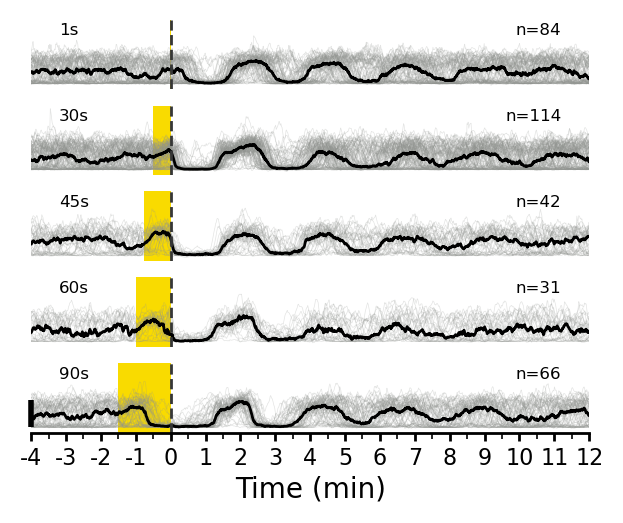

In [9]:
f = fig2.plot_beta_by_pulse_len(
    beta_comb_cut.crop((ms(minutes=-4), ms(minutes=12))).sel_isin(
        pulse_len=[
            ms(seconds=1),
            ms(seconds=30),
            ms(seconds=45),
            ms(seconds=60),
            ms(seconds=90),
        ])
)
fig2.savefig(f, 'beta_multiple_pulse_durations')

# Fig2def phase dependencty (& 90s from pulse start)

In [10]:
reg_sel = fig2.load_reg_healthy_no_cap_light_pulses()

analysis_windows = stim.collect_analysis_windows(reg_sel, pulse_len=(0, ms(minutes=4)), align_to='start').sel(noisy=False)

reg_sel = reg_sel.sel_mask(analysis_windows['exp_name'].unique())

exp_beta_detailed = reg_sel.load_all_beta_traces_multi(area='CLA').normalize_by_quantiles()

exp_beta_comb = exp_beta_detailed.groupby_max('exp_name')

Taking 71/204 experiments


  0%|          | 0/71 [00:00<?, ?it/s]

Found 479 pulses in total


load beta:   0%|          | 0/51 [00:00<?, ?it/s]

In [11]:
beta_acorrs = exp_beta_comb.crop((ms(hours=2), ms(hours=11))).auto_corr(pearson=True)
exp_beta_comb['cycle_length'] = cycles.estimate_interval(beta_acorrs)

cycles.plot_estimated_intervals(beta_acorrs, exp_beta_comb['cycle_length'])
;

''

In [12]:
exp_phase_comb = prc.collect_beta_phases(exp_beta_comb)
phase_comb_cut = prc.get_phase_cut(exp_phase_comb, analysis_windows, name='comb', phase_time=phase_time)

# we re-normalize because some artifacts late/early may shrink beta
# but the analysis windows are big enough to get reasonable statistics for normalization
beta_detailed_cut = exp_beta_detailed.cut_merge(analysis_windows).normalize_by_quantiles()
beta_comb_cut = beta_detailed_cut.groupby_max('win_idx').set_index('win_idx')

# copy over the combined phase
beta_comb_cut = beta_comb_cut.set_cols(phase_comb_cut[['phase_comb', 'phase_comb_cat']])

Saving: /gpfs/laur/data/fenkl/from_luis/fig2/phase_dependency.pdf


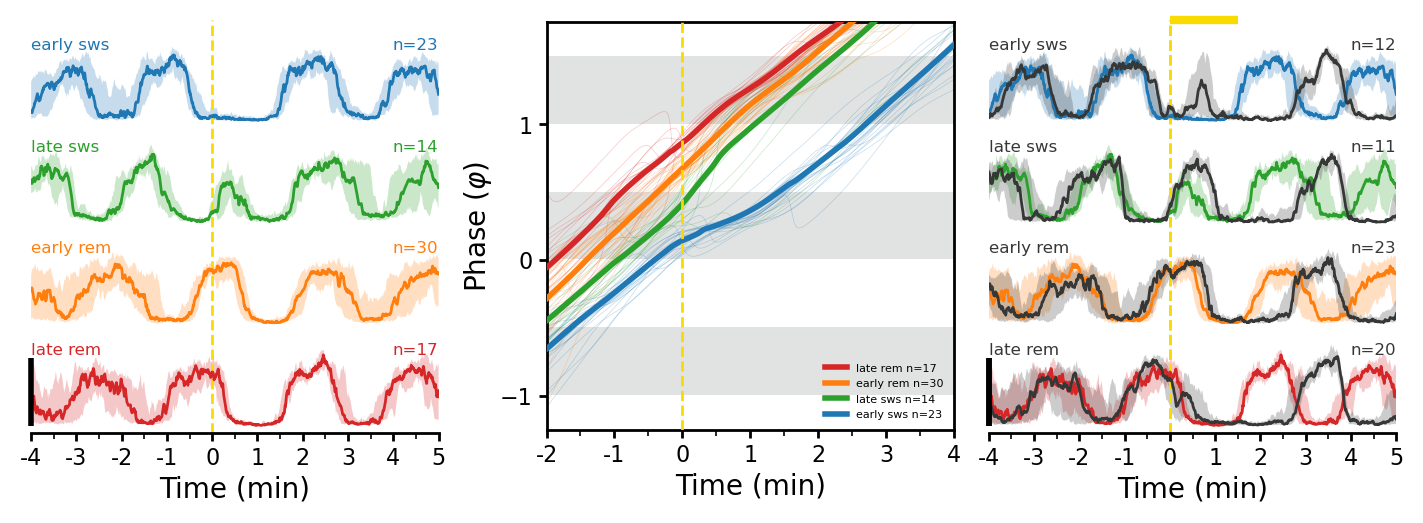

In [13]:
f = fig2.plot_phase_dependency(
    beta_comb_cut,
    phase_comb_cut,
    shaded=True,
)
fig2.savefig(f, f'phase_dependency')

In [14]:
phase_comb_cut['phase_diff'] = prc.take_phase_diff(phase_comb_cut, phase_time, class_by='phase_comb')


Saving: /gpfs/laur/data/fenkl/from_luis/fig2/prc.pdf


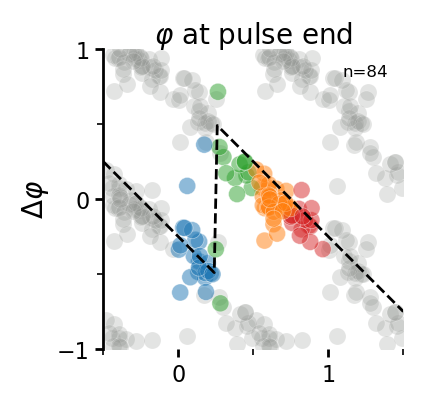

In [15]:
f, ax = plt.subplots(figsize=(2, 2))
prc_plot.plot_prc_single(ax, phase_comb_cut.sel(pulse_len=ms(seconds=1)), class_by='phase_comb')
fig2.savefig(f, f'prc')